In [1]:
import sys
sys.path.append("..")
from damage_indicator_module.damage_indicator_module import*

import copy
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
set_plot_formatting()

Color for each building

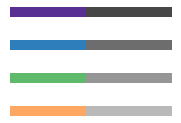

In [2]:
grayscale = False
n_colors = 4
min_intensity = 0.4 #0.6
max_intensity = 0.85

color_values = np.linspace(min_intensity, max_intensity, n_colors)
color_palettes = ['Oranges', 'Greens', 'Blues', 'Purples']
color_build = [mpl.cm.get_cmap(color_palettes[i])(color_values[i]) for i in range(len(color_values))] 
check_colors(color_build, 10)

### INPUTS

In [3]:
# Building results file
building_id = ['ID1008','ID1012','ID1014','ID1021']
im = 'sa_avg'

# Damage indicator names
di_types =  ["$SDR_{peak}$", "$RSDR_{peak}$", "$FDI_{peak}$", "$FDI_{max}^{bottom}$", "Beams DS$\geq$1", \
             "$Sa(T_1)^{mainshock}/Sa(T_1)^{DBE}$"]
x_tick_names = ["$SDR_{peak}$", "$SDR_{residual}$", "$FDI_{max}$", "$FDI_{max}^{bottom}$", \
                "Beams\nDS$\geq$1", "$Sa(T)^{main}/$\n$Sa(T)^{DBE}$"]


# Minimum value of each damage indicator to consider
di_min = [1e-4, 1e-6, 1e-7, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]

# Transformation for fit and display
di_transformation = "log"

n_scales = 7
n_mainshocks = 44


#### Retrieve damage indicator data per buildng

In [4]:
damage_instances_data = dict()
for b_i in building_id:
    damage_instances_data[b_i] = pd.read_hdf('../1_Data_postprocessing/Damage_Instances_per_building.h5', key=b_i)

#### Assemble Damage Indicator Matrix per building [check manually those related to fractions of damaged components]

In [5]:
damage_instances_matrix = dict()

for b_i in building_id:
    # Retrieve data of current building
    current_building = damage_instances_data[b_i]
    
    # Matrix of Damage Indicators per damage instance        
    di_matrix = current_building[di_types[0]]
    di_matrix = np.vstack((di_matrix, current_building[di_types[1]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[2]]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[3]]))
    di_matrix = np.vstack((di_matrix, 1 - np.stack(current_building['dsr_beams'].to_numpy())[:,0]))
    di_matrix = np.vstack((di_matrix, current_building[di_types[5]]))
    
    damage_instances_matrix[b_i] = copy.deepcopy(np.transpose(di_matrix))
del(di_matrix)

#### Reduction in median collapse capacity

In [6]:
k_min = 0.05

k = dict()

for b_i in building_id:
    # Retrieve data of current building
    k[b_i] = damage_instances_data[b_i]['$\kappa$'].values    
    damage_instances_matrix[b_i] = damage_instances_matrix[b_i][k[b_i] > k_min]
    damage_instances_data[b_i] = damage_instances_data[b_i][k[b_i] > k_min]
    k[b_i] = k[b_i][k[b_i] > k_min]

y_label = '$\kappa$' #'Fraction of $\widehat{Sa}_{collapse}^{Intact}$, $\kappa$'


#### Retrieve trilinear models

In [13]:
parameters = {}
for b_i in building_id:
    parameters[b_i] = pd.read_hdf('../1_Data_postprocessing/kappa_function_parameters.h5', key=b_i)   

### Fit trilinear model to combined data

In [14]:
N_seeds = 20

# Concatenate results for all buildings
di_comb = damage_instances_matrix[building_id[0]]
k_comb = k[building_id[0]]
columnBool_comb = damage_instances_data[building_id[0]]['column_damage?'].values
dsr_cols_comb = 1 - np.stack(damage_instances_data[building_id[0]]['dsr_columns'].to_numpy())[:,0]

for b_i in building_id[1:]:
    di_comb = np.vstack((di_comb, damage_instances_matrix[b_i]))
    k_comb = np.hstack((k_comb, k[b_i]))

# Fit trilinear function    
parameters_comb = pd.DataFrame()
for j, di in enumerate(di_types):        
    
    temp = fitPieceWiseFunc3LinLS(di, di_comb[:, j], k_comb, di_min[j], di_transformation, N_seeds)
    parameters_comb = parameters_comb.append(temp)

parameters['comb'] = parameters_comb
del(parameters_comb)

..\damage_indicator_module\damage_indicator_module\damage_indicators.py:619: RuntimeWarning: invalid value encountered in double_scalars
  b1_0 = np.sum(x1.dot(y1)) / np.sum(x1.dot(x1))
..\damage_indicator_module\damage_indicator_module\damage_indicators.py:535: RuntimeWarning: invalid value encountered in greater
  y_seg1 = y[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicator_module\damage_indicators.py:535: RuntimeWarning: invalid value encountered in less_equal
  y_seg1 = y[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicator_module\damage_indicators.py:536: RuntimeWarning: invalid value encountered in greater
  y_seg2 = y[x > param[2]]
..\damage_indicator_module\damage_indicator_module\damage_indicators.py:538: RuntimeWarning: invalid value encountered in greater
  y_pred_seg1 = y_pred[np.logical_and(x > param[1], x <= param[2])]
..\damage_indicator_module\damage_indicator_module\damage_indicators.py:538: Run

### Plot scatter and trilinear regression

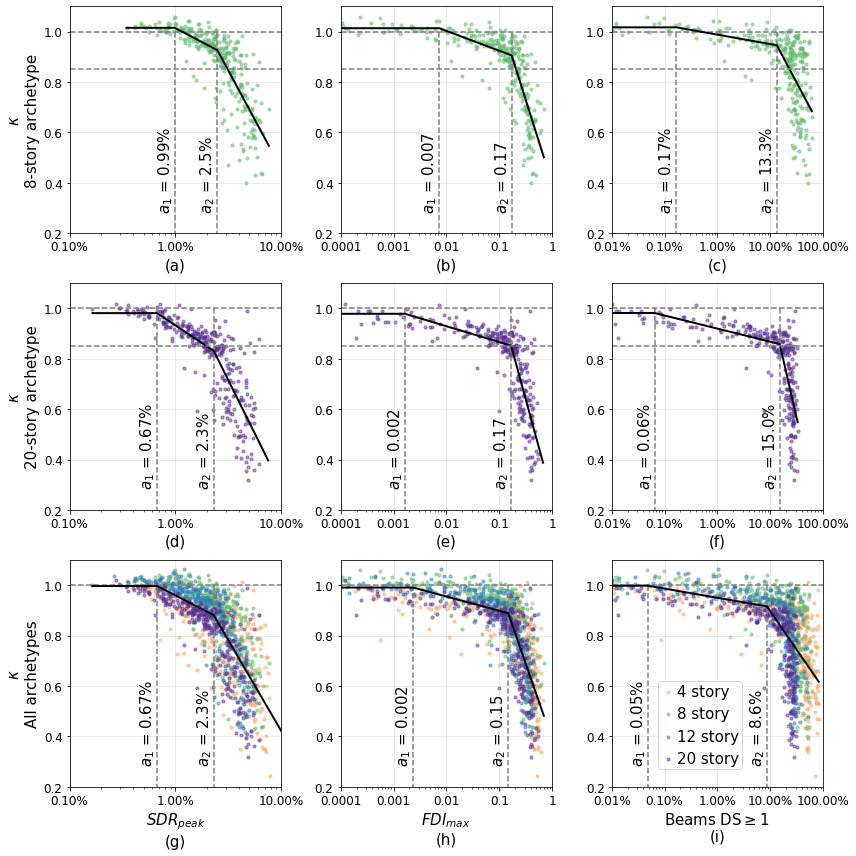

In [15]:
# Plot the reduction in collapse capacity vs damage indicator
fig = plt.figure(figsize=(12, 12))

k_limit = 0.85


di_to_plot = ["$SDR_{peak}$", "$FDI_{peak}$", "Beams DS$\geq$1"]
di_index = [0, 2, 4]

building_to_plot = ['ID1012', 'ID1021', 'comb']
bi_index = [1, 3]

x_limits_plot = [[0.001, 0.1], [1e-4, 1], [0.0001, 1]]
y_labels = [y_label + '\n8-story archetype', '', '', y_label + '\n20-story archetype', '', '', y_label + '\nAll archetypes', '', '']
x_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

plot_i = 0
for i, b_i in enumerate(building_to_plot):    
    
    if b_i != 'comb':
        bi_i = bi_index[i]
        
        for j, di_name in enumerate(di_to_plot):
            di_i = di_index[j]

            di_matrix = damage_instances_matrix[b_i]

            # Plot trilinear function
            plotDIvsk3Lin(x_limits_plot[j], parameters[b_i].loc[[di_name]], y_labels[plot_i], \
                          di_transformation, plot_i, 'w', 'k','')  
            
            # Formatting
            _ = plt.xlabel('(' + x_labels[plot_i] + ')')
            
            # Plot scatter
            if  di_name == "$SDR_{peak}$" or di_name == "$RSDR_{peak}$" or di_name == "Beams DS$\geq$1" or di_name == "Columns DS$\\geq$1": 
                   ax = plt.scatter(di_matrix[:, di_i]*100, k[b_i], s=10, Color = color_build[bi_i], alpha=0.5)
            else:
                  ax = plt.scatter(di_matrix[:, di_i], k[b_i], s=10, Color = color_build[bi_i], alpha=0.5)

            # Plot threshold line
            if  di_name == "$SDR_{peak}$" or di_name == "$RSDR_{peak}$" or di_name == "Beams DS$\geq$1" or di_name == "Columns DS$\\geq$1":     
                _ = plt.plot(100*np.array(x_limits_plot[j]), [k_limit, k_limit], linestyle='--', Color='gray')
            else:
                _ = plt.plot(x_limits_plot[j], [k_limit, k_limit], linestyle='--', Color='gray')

            plot_i += 1
            
    else:
            for j, di_name in enumerate(di_to_plot):
                di_i = di_index[j]

                # Plot trilinear function
                plotDIvsk3Lin(x_limits_plot[j], parameters['comb'].loc[[di_name]], y_labels[plot_i], \
                              di_transformation, plot_i, 'w', 'k','')  

                # Plot data color codes per building
                for i, b_i in enumerate(building_id):
                    if  di_name == "$SDR_{peak}$" or di_name == "$RSDR_{peak}$" or di_name == "Beams DS$\geq$1" or di_name == "Columns DS$\\geq$1":             
                        _ = plt.scatter(damage_instances_matrix[b_i][:, di_i]*100, k[b_i], s=10, color=color_build[i], alpha = 0.5)
                    else:
                        _ = plt.scatter(damage_instances_matrix[b_i][:, di_i], k[b_i], s=10, color=color_build[i], alpha = 0.5)
                    
                # Formatting
                if di_name == "$SDR_{peak}$":
                    _ = plt.xlabel("$SDR_{peak}$ \n(g)")
                if di_name == "DI hinges":
                    _ = plt.xlabel("$DI_{hinges}$")  
                if di_name == "$FDI_{peak}$":
                    _ = plt.xlabel("$FDI_{max}$ \n(h)")  
                if di_name == "Beams DS$\geq$1":
                    _ = plt.xlabel("Beams DS$\geq$1 \n(i)")
                
                if plot_i == 0:
                    _ = plt.ylabel(y_label)
            #         _ = plt.legend(['4 story', '8 story', '12 story', '20 story'], frameon=False)
                    legend = [Line2D([0], [0], label='4 story', color=color_build[0], marker="o"),
                              Line2D([0], [0], label='8 story', color=color_build[1], marker="o"),
                              Line2D([0], [0], label='12 story', color=color_build[2], marker="o"),
                              Line2D([0], [0], label='20 story', color=color_build[3], marker="o")]
                
                plot_i += 1        
        
    plt.tight_layout()

legend_names = ['4 story', '8 story', '12 story', '20 story']
_ = plt.legend(legend_names, ncol = 1, loc='best', bbox_to_anchor=(0.28, 0., 0.37, 0.5), 
               handletextpad=0.05, borderpad=0.2, handlelength=1)
    

plt.savefig('kappa_vs_DI.pdf')

### Efficiency

In [16]:
error_metric = 'abs' # 'abs' 'squared'

MAE = dict()

for bi in building_id:
    di_matrix = damage_instances_matrix[bi] 
    MAE_temp = np.zeros(len(di_types))
    for j, di in enumerate(di_types):
        x = di_matrix[:, j]
        y = k[bi]
        y_pred = predictPieceWiseFunc3LinLS(x, parameters[bi].iloc[j], di_transformation)
        
        if error_metric == 'abs':
            MAE_temp[j] = 1 / len(x) * np.sum(np.abs(y_pred - y))
        else:
            error = (y_pred - y).reshape(-1, 1)
            MAE_temp[j] = 1 / len(x) * error.T.dot(error)
        
    MAE[bi] = copy.deepcopy(MAE_temp)


# MAE_temp = np.zeros((splits*repeats,len(di_types)))
MAE_temp = np.zeros(len(di_types))
for j, di in enumerate(di_types):
    x = di_comb[:, j]
    y = k_comb
    y_pred = predictPieceWiseFunc3LinLS(x, parameters['comb'].iloc[j], di_transformation)
    
    if error_metric == 'abs':
        MAE_temp[j] = 1 / len(x) * np.sum(np.abs(y_pred - y))
    else:
        error = (y_pred - y).reshape(-1, 1)
        MAE_temp[j] = 1 / len(x) * error.T.dot(error)

MAE['comb'] = copy.deepcopy(MAE_temp)
del(MAE_temp)

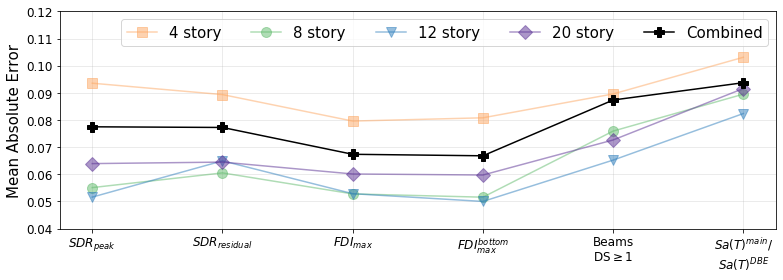

In [17]:
fig = plt.figure(figsize=(11, 4))

groups = np.arange(len(di_types))
legend_names = ['4 story', '8 story', '12 story', '20 story', 'Combined']
bar_width = 0.1
marker_type = ['s', 'o', 'v', 'D', 'P']


# for i in range(len(building_id)+1):
#     _ = plt.bar(groups + bar_width*(i-2), AMAE[i, :], width = bar_width)
for i, bi in enumerate(building_id):
    _ = plt.plot(groups, MAE[bi], marker = marker_type[i], alpha = 0.5, markersize = 10, color = color_build[i])
_ = plt.plot(groups, MAE['comb'], color = 'black', marker = marker_type[len(building_id)], markersize = 10)

# _ = plt.title("Efficiency")
_ = plt.ylabel('Mean Absolute Error')

_ = plt.xticks(groups, x_tick_names)
# _ = plt.xlim([-bar_width*len(building_id), 2.35*bar_width*len(di_types)*len(building_id)])
_ = plt.ylim([0.04, 0.12])
_ = plt.grid(which = 'both',alpha = 0.3)
_ = plt.legend(legend_names, ncol=len(legend_names), loc='best')

plt.tight_layout()
plt.savefig('Efficiency_MAE.pdf')

### Combined regression model

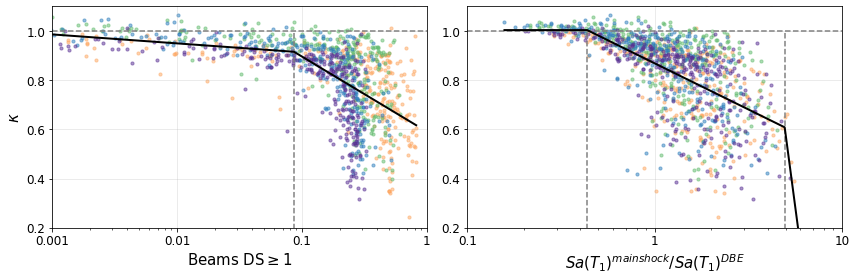

In [18]:
# Plot combined results
fig = plt.figure(figsize=(12, 4))

x_limits_plot = [[0.001, 1.0], [0.1, 10]]

di_to_plot = [4, 5] #['$SDR_{peak}$', 'Columns DS>0']

plot_i = 0
for j in di_to_plot:
    
    ax = plt.subplot2grid((1, 2), (0, plot_i), rowspan=1, colspan=1)

    # Plot regression line with combined data
    a_plot = parameters['comb'].loc[di_types[j]]["di for plot"]
    k_plot = parameters['comb'].loc[di_types[j]]["k for plot"]
    _ = plt.plot(a_plot, k_plot, linewidth=2.0, color='k', label='_nolegend_', zorder=5)
    ax = plt.plot([a_plot[1], a_plot[1]], [0, 1], linestyle='--', Color='gray', label='_nolegend_')
    ax = plt.plot([a_plot[2], a_plot[2]], [0, 1], linestyle='--', Color='gray', label='_nolegend_')
    ax = plt.plot(x_limits_plot[plot_i], [1, 1], linestyle='--', Color='gray', label='_nolegend_')

    # Plot data color codes per building
    for i, b_i in enumerate(building_id):
        _ = plt.scatter(damage_instances_matrix[b_i][:, j], k[b_i], s=10, color=color_build[i], alpha = 0.5)
    
    # Formatting
    if di_types[j] == '$FDI_{peak}$':
        _ = plt.xlabel('$FDI_{max}$')
    else:
        ax = plt.xlabel(di_types[j])
    if plot_i == 0:
        _ = plt.ylabel(y_label)
#         _ = plt.legend(['4 story', '8 story', '12 story', '20 story'], frameon=False)
        legend = [Line2D([0], [0], label='4 story', color=color_build[0], marker="o"),
                  Line2D([0], [0], label='8 story', color=color_build[1], marker="o"),
                  Line2D([0], [0], label='12 story', color=color_build[2], marker="o"),
                  Line2D([0], [0], label='20 story', color=color_build[3], marker="o")]

    ax = plt.xlim(x_limits_plot[plot_i])
    ax = plt.ylim([0.2, 1.1])
    ax = plt.grid(which='major', alpha=0.3)
    
    ax = plt.xscale('log')
    ax = plt.gca()
    _ = ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.2g}'.format(y)))
    
    plot_i += 1
    
plt.subplots_adjust(wspace=0.15)
plt.tight_layout()
plt.savefig('kappa_vs_DI_combined.pdf')